### Much of this has been adopted from my CIS 545 final project, which can be found [here](https://colab.research.google.com/drive/1UQHIT0rkx16J_g5VqShsN0Ydcwwt4M89?usp=sharing)

In [2]:
!pip install --upgrade mxnet==1.6
!pip install sdv

from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

import numpy as np
np.bool = np.bool_

# mxnet setup
import mxnet as mx
from mxnet import np
from mxnet import gluon, autograd, ndarray
from mxnet import npx
from mxnet.gluon import nn
npx.set_np()
npx.num_gpus()

# sklearn Setup
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Pandas Setup
import json
import glob
import pandas as pd
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import dates as mdates
from matplotlib.lines import Line2D

  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sdv 1.10.0 requires graphviz<1,>=0.13.2, but you have graphviz 0.8.4 which is incompatible.
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.6.0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.20.1 which is incompatible.


In [3]:
# create a context, loss criterion, accuracy metric, and trainer for the FNN model which it also initializes
def create_ctx_criterion_metric_trainer(net, optimizer, learning_rate):
  ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu() # use available GPUs or resort to CPUs
  net.initialize(mx.init.Xavier(), ctx=ctx) # initialize network
  criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss() # define loss criterion
  metric = mx.metric.Accuracy() # define accuracy metric
  trainer = mx.gluon.Trainer(net.collect_params(),optimizer=optimizer,optimizer_params={'learning_rate':learning_rate})
  return ctx, criterion, metric, trainer

In [4]:
# split data into train / test sections & then load it into data loaders that can be used by mxnet
def split_and_load(df, label, batch_size):
  # specify features and split
  features = df.drop(columns = ["reputation_score"])
  x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.2, random_state = 1900)

  # parse data to make it loadable into mxnet data loader
  y_train = np.array(y_train.to_numpy().reshape(-1,1), dtype=np.float32)
  y_test = np.array(y_test.to_numpy().reshape(-1,1), dtype=np.float32)
  x_train = np.array(x_train.to_numpy(), dtype=np.float32)
  x_test = np.array(x_test.to_numpy(), dtype=np.float32)

  # define data loaders
  train_dataset = mx.gluon.data.dataset.ArrayDataset(x_train, y_train)
  train_loader = mx.gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataset = mx.gluon.data.dataset.ArrayDataset(x_test, y_test)
  test_loader = mx.gluon.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

  return train_loader, test_loader

In [5]:
# the 'print' param determines whether to print progress or not
def train_network(net, train_loader, epochs, learning_rate, optimizer, printOut = True):
  if printOut:
    print("-------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------")
    print("Training FNN...")
  accuracy_list = []
  loss_list = []
  for e in range(1, epochs + 1):
    epoch_loss = 0.0
    epoch_databatch_size = 0.0
    metric.reset() # reset loss at each record
    for i, (data, labels) in enumerate(train_loader):
      data = data.as_in_context(ctx)
      labels = labels.as_in_context(ctx)
      with autograd.record():
        z = net(data) # make the actual predictions
        loss = criterion(z,labels)
        metric.update(preds = z.as_nd_ndarray(),labels = labels)
      loss.backward()
      trainer.step(data.shape[0])
      epoch_databatch_size += data.shape[0]
      epoch_loss += mx.nd.sum(loss.as_nd_ndarray()).asscalar()
    accuracy_list.append(metric.get()[1])
    loss_list.append(epoch_loss/epoch_databatch_size)
    if printOut:
      print(f'The loss for Epoch {e} is: {epoch_loss/epoch_databatch_size}. The accuracy for Epoch {e} is {metric.get()[1]}')
  if printOut:
    print("Finished training.")
    print("-------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------")
  return accuracy_list, loss_list

In [6]:
# test the model on the test data
def test_model(net, test_loader, optimizer, printOut = True):
  if printOut:
    print("\nTesting FNN...")
  metric = mx.metric.Accuracy()
  databatch_size = 0.0
  cumulative_loss = 0.0
  for i, (data, labels) in enumerate(test_loader):
      data = data.as_in_context(ctx)
      labels = labels.as_in_context(ctx)
      with autograd.record():
        z = net(data) # make the actual predictions
        loss = criterion(z,labels)
        metric.update(preds = z.as_nd_ndarray(),labels = labels)
      databatch_size += data.shape[0]
      cumulative_loss += mx.nd.sum(loss.as_nd_ndarray()).asscalar()
  testing_accuracy = metric.get()[1]
  testing_loss = cumulative_loss / databatch_size
  if printOut:
    print("-------------------------------------------------------------------------------------------")
    print(f"The loss for running the FNN on the test data is {testing_loss}. The accuracy is {testing_accuracy}")
    print("-------------------------------------------------------------------------------------------")
  return testing_accuracy

In [7]:
# plot the accuracy and loss of the model
def plot_training(accuracy_list, loss_list, num_epochs, title):
  f,ax = plt.subplots(figsize=(10, 7))
  fnn_g = sns.lineplot(x=range(1,num_epochs + 1),y=accuracy_list,marker='o',color='g')
  ax2 = fnn_g.axes.twinx()
  sns.lineplot(x=range(1,num_epochs + 1),y=loss_list,marker='o',color='b',ax=ax2)
  fnn_g.legend(handles=[Line2D([], [], marker='_', color="g", label='Training Accuracy'),
                        Line2D([], [], marker='_', color="b", label='Training Loss')],loc='upper center')
  fnn_g.set_xlabel('Number of training epochs elapsed',fontsize=13)
  ax.set_ylabel('Training accuracy',fontsize=13,color="g")
  ax2.set_ylabel('Training loss',fontsize=13,color="b")
  fnn_g.set_title(f'FNN {title} - Training accuracy and loss as function of a number of training epochs',fontsize=15)
  plt.show()

In [17]:
df = pd.read_csv("synthetic_data.csv")

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 1439.4641479492188. The accuracy for Epoch 1 is 0.047375
The loss for Epoch 2 is: 1365.72883984375. The accuracy for Epoch 2 is 0.04825
The loss for Epoch 3 is: 1291.6823447265624. The accuracy for Epoch 3 is 0.05
The loss for Epoch 4 is: 1217.893517578125. The accuracy for Epoch 4 is 0.052
The loss for Epoch 5 is: 1146.6071552734375. The accuracy for Epoch 5 is 0.061
The loss for Epoch 6 is: 1083.6230356445312. The accuracy for Epoch 6 is 0.062875
The loss for Epoch 7 is: 1021.2791501464844. The accuracy for Epoch 7 is 0.062375
The loss for Epoch 8 is: 958.3252912597657. The accuracy for Epoch 8 is 0.06375
The loss for Epoch 9 is: 894.7197888183593. The accuracy for Epoch 9 is 0.063625
The loss for Epoch 10 is: 830.7595151367187. The accuracy for Epoch 10 is 0.065

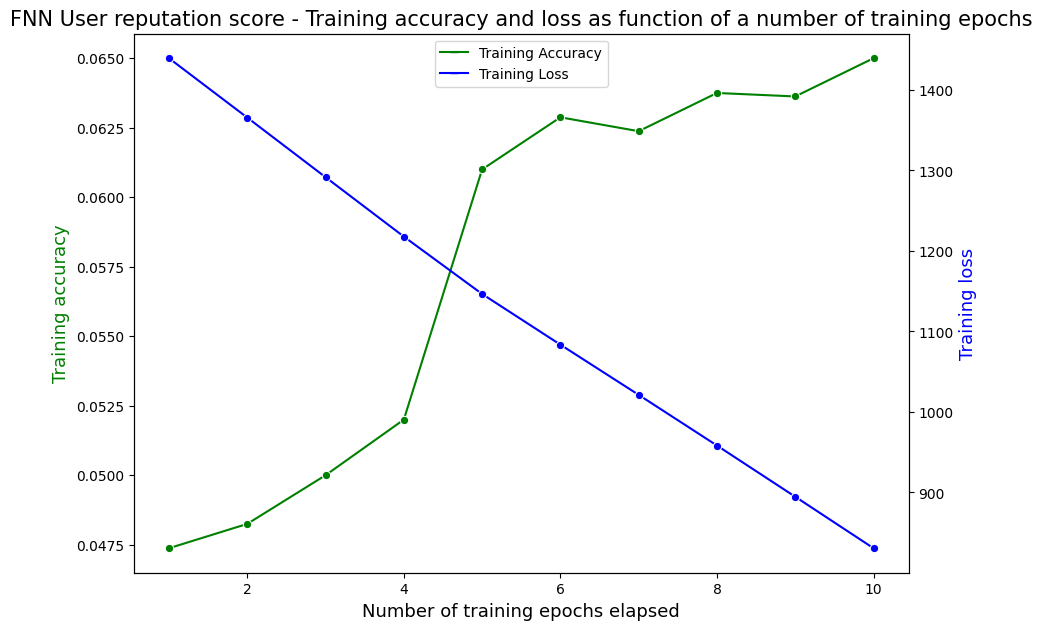

In [18]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(10)) # 10 since 10 different ratings

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(df, df['reputation_score'], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "User reputation score")

We get the highest testing accuracy (21.65%) with 1 inner layers and 500 neurons per layer


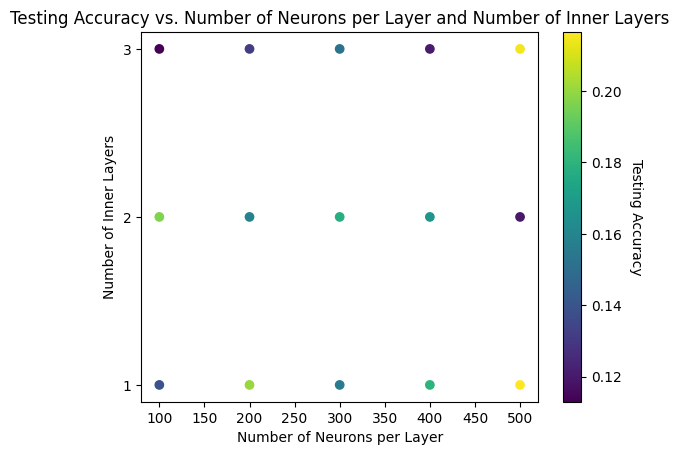

In [19]:
combos_dict = {}
num_neuron_lst = []
depth_lst = []
acc_lst = []

# make one global train/test split used by each call
train_loader, test_loader = split_and_load(df, df['reputation_score'], 50)

for j in range(100,501,100): # limit each layer at 500, step by 100
  for i in range(1,4): # do at most 4 layers
    net = gluon.nn.Sequential()
    with net.name_scope():
      for k in range(1,i+1): # do at most 4 layers
          net.add(nn.Dense(j,activation='relu'))
      net.add(nn.Dense(10)) # last layer has 4 labels

    ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam',0.0001)

    train_network(net, train_loader, 7, 0.0001, 'adam',printOut=False)
    test_acc = test_model(net, test_loader, 'adam', printOut=False)
    combos_dict[(i, j)] = test_acc # record current accuracy with current j,i combo
    acc_lst.append(test_acc)
    num_neuron_lst.append(j)
    depth_lst.append(i)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print(f"We get the highest testing accuracy ({round(max_acc * 100, 2)}%) with {best_combo[0]}\
 inner layers and {best_combo[1]} neurons per layer")

fig, ax = plt.subplots();
d_points = ax.scatter(num_neuron_lst, depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Neurons per Layer");
ax.set_ylabel("Number of Inner Layers");
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Testing Accuracy vs. Number of Neurons per Layer and Number of Inner Layers");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

In [25]:
for elt in ['sigmoid','relu','tanh']:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation=elt))
    net.add(nn.Dense(10))

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

  train_loader, test_loader = split_and_load(df, df['reputation_score'], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, 0.0001, 'adam',printOut=False)
  print(f"{elt}: ")
  test_model(net, test_loader, 'adam')

sigmoid: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.0852124852538108. The accuracy is 0.2205
-------------------------------------------------------------------------------------------
relu: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.750408344981726. The accuracy is 0.1685
-------------------------------------------------------------------------------------------
tanh: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.0836710197925568. The accuracy is 0.2175
-------------------------------------------------------------------------------------------


In [ ]:
for elt in [0.01, 0.001, 0.0001]:
  net = gluon.nn.Sequential()
  with net.name_scope():
    net.add(nn.Dense(500,activation="sigmoid"))
    net.add(nn.Dense(10))

  ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', elt)

  train_loader, test_loader = split_and_load(df, df['reputation_score'], 50)
  accuracy_list, loss_list = train_network(net, train_loader, 5, elt, 'adam',printOut=False)
  print(f"Learning rate {elt}: ")
  test_model(net, test_loader, 'adam')

Learning rate 0.01: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.16127828502655. The accuracy is 0.162
-------------------------------------------------------------------------------------------
Learning rate 0.001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.110671391248703. The accuracy is 0.161
-------------------------------------------------------------------------------------------
Learning rate 0.0001: 

Testing FNN...
-------------------------------------------------------------------------------------------
The loss for running the FNN on the test data is 2.0849045500159264. The accuracy is 0.224
-------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
Training FNN...
The loss for Epoch 1 is: 2.1112488441467283. The accuracy for Epoch 1 is 0.1985
The loss for Epoch 2 is: 2.07880205821991. The accuracy for Epoch 2 is 0.206625
The loss for Epoch 3 is: 2.076406319618225. The accuracy for Epoch 3 is 0.21325
The loss for Epoch 4 is: 2.073976656913757. The accuracy for Epoch 4 is 0.21225
The loss for Epoch 5 is: 2.073692060470581. The accuracy for Epoch 5 is 0.214625
The loss for Epoch 6 is: 2.0711974563598634. The accuracy for Epoch 6 is 0.212375
The loss for Epoch 7 is: 2.071898579597473. The accuracy for Epoch 7 is 0.216
The loss for Epoch 8 is: 2.069851071357727. The accuracy for Epoch 8 is 0.218625
The loss for Epoch 9 is: 2.0695260992050173. The accuracy for Epoch 9 is 0.22175
The loss for Epoch 10 is: 2.0682528762817385. The accuracy for Epoch 10 is 0.

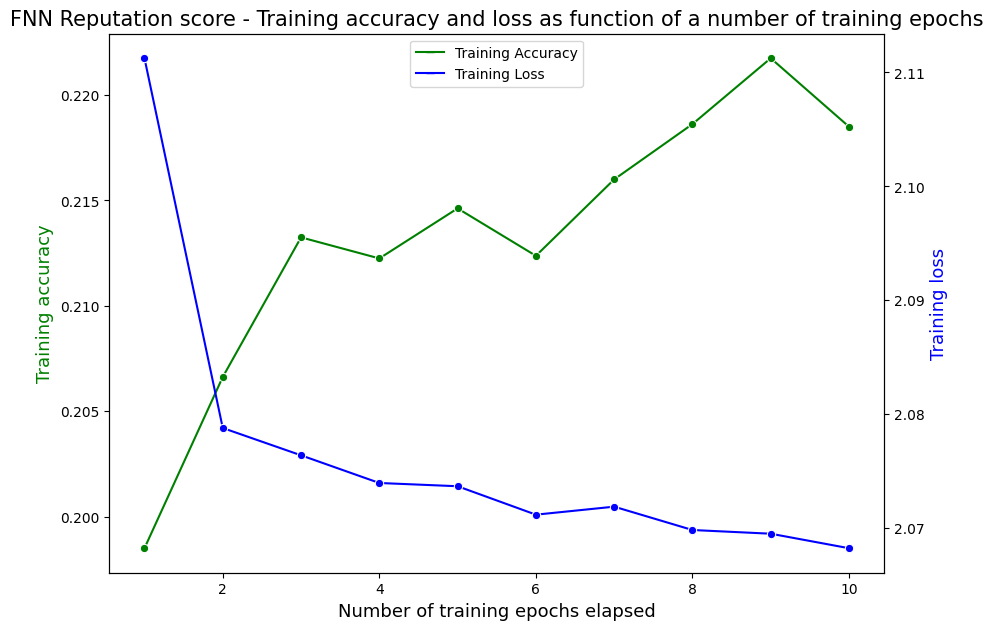

In [28]:
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Dense(500,activation="sigmoid"))
  net.add(nn.Dense(10))

ctx, criterion, metric, trainer = create_ctx_criterion_metric_trainer(net,'adam', 0.0001)

train_loader, test_loader = split_and_load(df, df['reputation_score'], 50)
accuracy_list, loss_list = train_network(net, train_loader, 10, 0.0001, 'adam')
test_model(net, test_loader, 'adam')
plot_training(accuracy_list, loss_list, 10, "Reputation score")